In [1]:
import os
import sys
import lightgbm as lgb
import polars as pl
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Setup paths
NOTEBOOK_DIR = os.getcwd()  # data_analysis
PROJ_DIR = os.path.dirname(NOTEBOOK_DIR)  # main project folder
MODEL_DIR = os.path.join(PROJ_DIR, "trained_models")
DATA_DIR = os.path.join(PROJ_DIR, "feature_enhanced_data/null_flags_and_forward_fill.parquet")

# Add training source to path for imports
sys.path.append(os.path.join(PROJ_DIR, "training"))
sys.path.append(os.path.join(PROJ_DIR, "training", "src"))
sys.path.append(os.path.join(PROJ_DIR, "training", "src", "utils"))

# Import our utility functions
from src.data_loading import DataLoader
from src.utils.metrics import r2_score_weighted

In [2]:
# Configuration
SEGMENT_LENGTH = 1  # Length of validation segments

# Define models and their training end days
MODELS = [
    {"name": "first_250.txt", "train_end": 250},
    {"name": "first_500.txt", "train_end": 500},
    {"name": "first_750.txt", "train_end": 750},
    {"name": "first_1000.txt", "train_end": 1000},
    {"name": "first_1250.txt", "train_end": 1250},
    {"name": "first_1500.txt", "train_end": 1500}
]

In [3]:
def load_model(model_path: str) -> lgb.Booster:
    """Load the LightGBM model"""
    return lgb.Booster(model_file=model_path)

In [4]:
def create_validation_segments(df: pl.DataFrame, start_days: list, segment_length: int) -> dict:
   """Create list of validation segments for each model's start day"""
   segments_by_model = {}
   
   for start_day in start_days:
       # Get unique sorted days after start_day
       all_days = (df.select('date_id')
                   .unique()
                   .filter(pl.col('date_id') > start_day)
                   .sort('date_id')
                   .get_column('date_id')
                   .to_list())
       
       segments = []
       # Step by segment_length to create non-overlapping segments
       for i in range(0, len(all_days) - segment_length + 1, segment_length):
           segment_days = all_days[i:i + segment_length]
           segments.append({
               'start_day': segment_days[0],
               'end_day': segment_days[-1],
               'days': segment_days
           })
           
       print(f"\nFor model trained until day {start_day}:")
       print(f"Created segments from {len(all_days)} unique days")
       print(f"First segment: Days {segments[0]['start_day']} to {segments[0]['end_day']}")
       print(f"Last segment: Days {segments[-1]['start_day']} to {segments[-1]['end_day']}")
       
       segments_by_model[start_day] = segments
   
   return segments_by_model

In [5]:
def evaluate_segment(models: dict, df: pl.DataFrame, segment: dict, exclude_cols: list) -> dict:
   """Evaluate all models on a specific segment"""
   # Filter data for segment
   segment_mask = pl.col('date_id').is_in(segment['days'])
   segment_data = df.filter(segment_mask)
   
   # Get features (everything not in exclude_cols)
   X = segment_data.select([
       col for col in segment_data.columns 
       if col not in exclude_cols + ['responder_6']
   ]).to_numpy()
   
   y_true = segment_data.select('responder_6').to_numpy().ravel()
   weights = segment_data.select('weight').to_numpy().ravel()
   
   # Base results dictionary
   results = {
       'start_day': segment['start_day'],
       'end_day': segment['end_day'],
       'n_samples': len(y_true),
       'mean_weight': weights.mean(),
       'std_weight': weights.std()
   }
   
   # Calculate metrics for each model
   for model_name, model in models.items():
       y_pred = model.predict(X)
       r2 = r2_score_weighted(y_true, y_pred, weights)
       results[f'r2_score_{model_name}'] = r2
   
   return results

In [6]:
# Load data using DataLoader
print("Loading data...")
data_loader = DataLoader(DATA_DIR)
train = pl.scan_parquet(DATA_DIR).select(
   pl.int_range(pl.len(), dtype=pl.UInt64).alias("id") if 'id' not in pl.scan_parquet(data_loader.data_path).columns else pl.col("id"),
   pl.all().exclude("id"),
)   

# Get feature columns and exclude columns
feature_cols, exclude_cols = data_loader.get_feature_columns(train)

# Collect to DataFrame but stay in Polars
print("Collecting DataFrame...")
df = train.collect(parallel=True)
print(f"Loaded DataFrame shape: {df.shape}")

print("Loading models...")
models = {}
for model_config in MODELS:
   model_name = model_config['name']
   print(f"Loading {model_name}...")
   models[model_name] = load_model(os.path.join(MODEL_DIR, model_name))

# Create validation segments for each model
print("\nCreating validation segments...")
segments_by_model = create_validation_segments(
   df, 
   [model_config['train_end'] for model_config in MODELS],
   SEGMENT_LENGTH
)

# Evaluate each segment for each model
print("\nEvaluating segments...")
results = []

# Use the segments specific to each model's training period
for segment in tqdm(segments_by_model[MODELS[0]['train_end']], desc="Evaluating segments"):
    result = {
        'start_day': segment['start_day'],
        'end_day': segment['end_day'],
        'n_samples': None,  # Will be set on first evaluation
        'mean_weight': None,
        'std_weight': None
    }
    
    # Only evaluate models that were trained before this segment
    for model_config in MODELS:
        model_name = model_config['name']
        train_end = model_config['train_end']
        
        if segment['start_day'] > train_end:
            # Evaluate this model on this segment
            segment_result = evaluate_segment(
                {model_name: models[model_name]}, 
                df, 
                segment, 
                exclude_cols
            )
            
            # Copy over the common metrics if not yet set
            if result['n_samples'] is None:
                result.update({
                    'n_samples': segment_result['n_samples'],
                    'mean_weight': segment_result['mean_weight'],
                    'std_weight': segment_result['std_weight']
                })
            
            # Add this model's R² score
            result[f'r2_score_{model_name}'] = segment_result[f'r2_score_{model_name}']
    
    results.append(result)

# Convert results to DataFrame
results_df = pd.DataFrame(results)

Loading data...


/tmp/ipykernel_3996222/149718195.py:5: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  pl.int_range(pl.len(), dtype=pl.UInt64).alias("id") if 'id' not in pl.scan_parquet(data_loader.data_path).columns else pl.col("id"),



📊 Analyzing column structure...
Found 158 features and 12 columns to exclude
Loaded DataFrame shape: (47127338, 173)
Loading models...
Loading first_250.txt...
Loading first_500.txt...
Loading first_750.txt...
Loading first_1000.txt...
Loading first_1250.txt...
Loading first_1500.txt...

Creating validation segments...

For model trained until day 250:
Created segments from 1448 unique days
First segment: Days 251 to 251
Last segment: Days 1698 to 1698

For model trained until day 500:
Created segments from 1198 unique days
First segment: Days 501 to 501
Last segment: Days 1698 to 1698

For model trained until day 750:
Created segments from 948 unique days
First segment: Days 751 to 751
Last segment: Days 1698 to 1698

For model trained until day 1000:
Created segments from 698 unique days
First segment: Days 1001 to 1001
Last segment: Days 1698 to 1698

For model trained until day 1250:
Created segments from 448 unique days
First segment: Days 1251 to 1251
Last segment: Days 1698 to 

Evaluating segments: 100%|██████████| 1448/1448 [10:51<00:00,  2.22it/s]


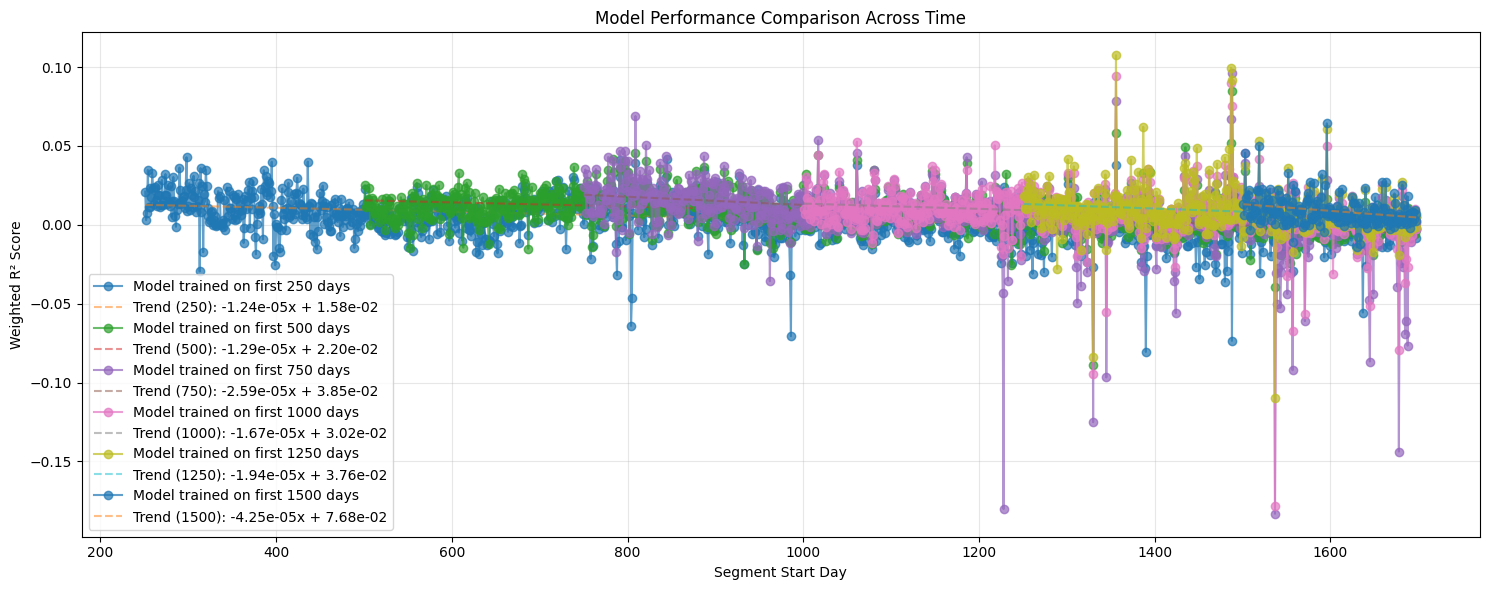

In [7]:
# Plot performance across time
plt.figure(figsize=(15, 6))
for model_config in MODELS:
    model_name = model_config['name']
    r2_col = f'r2_score_{model_name}'
    
    # Get non-null values for this model
    valid_results = results_df[['start_day', r2_col]].dropna()
    
    # Plot scores
    plt.plot(valid_results['start_day'], valid_results[r2_col], marker='o', 
            label=f'Model trained on first {model_config["train_end"]} days', alpha=0.7)
    
    # Add trend line
    z = np.polyfit(valid_results['start_day'], valid_results[r2_col], 1)
    p = np.poly1d(z)
    plt.plot(valid_results['start_day'], p(valid_results['start_day']), "--", alpha=0.5,
             label=f'Trend ({model_config["train_end"]}): {z[0]:.2e}x + {z[1]:.2e}')

plt.title('Model Performance Comparison Across Time')
plt.xlabel('Segment Start Day')
plt.ylabel('Weighted R² Score')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

<Figure size 1500x1000 with 0 Axes>

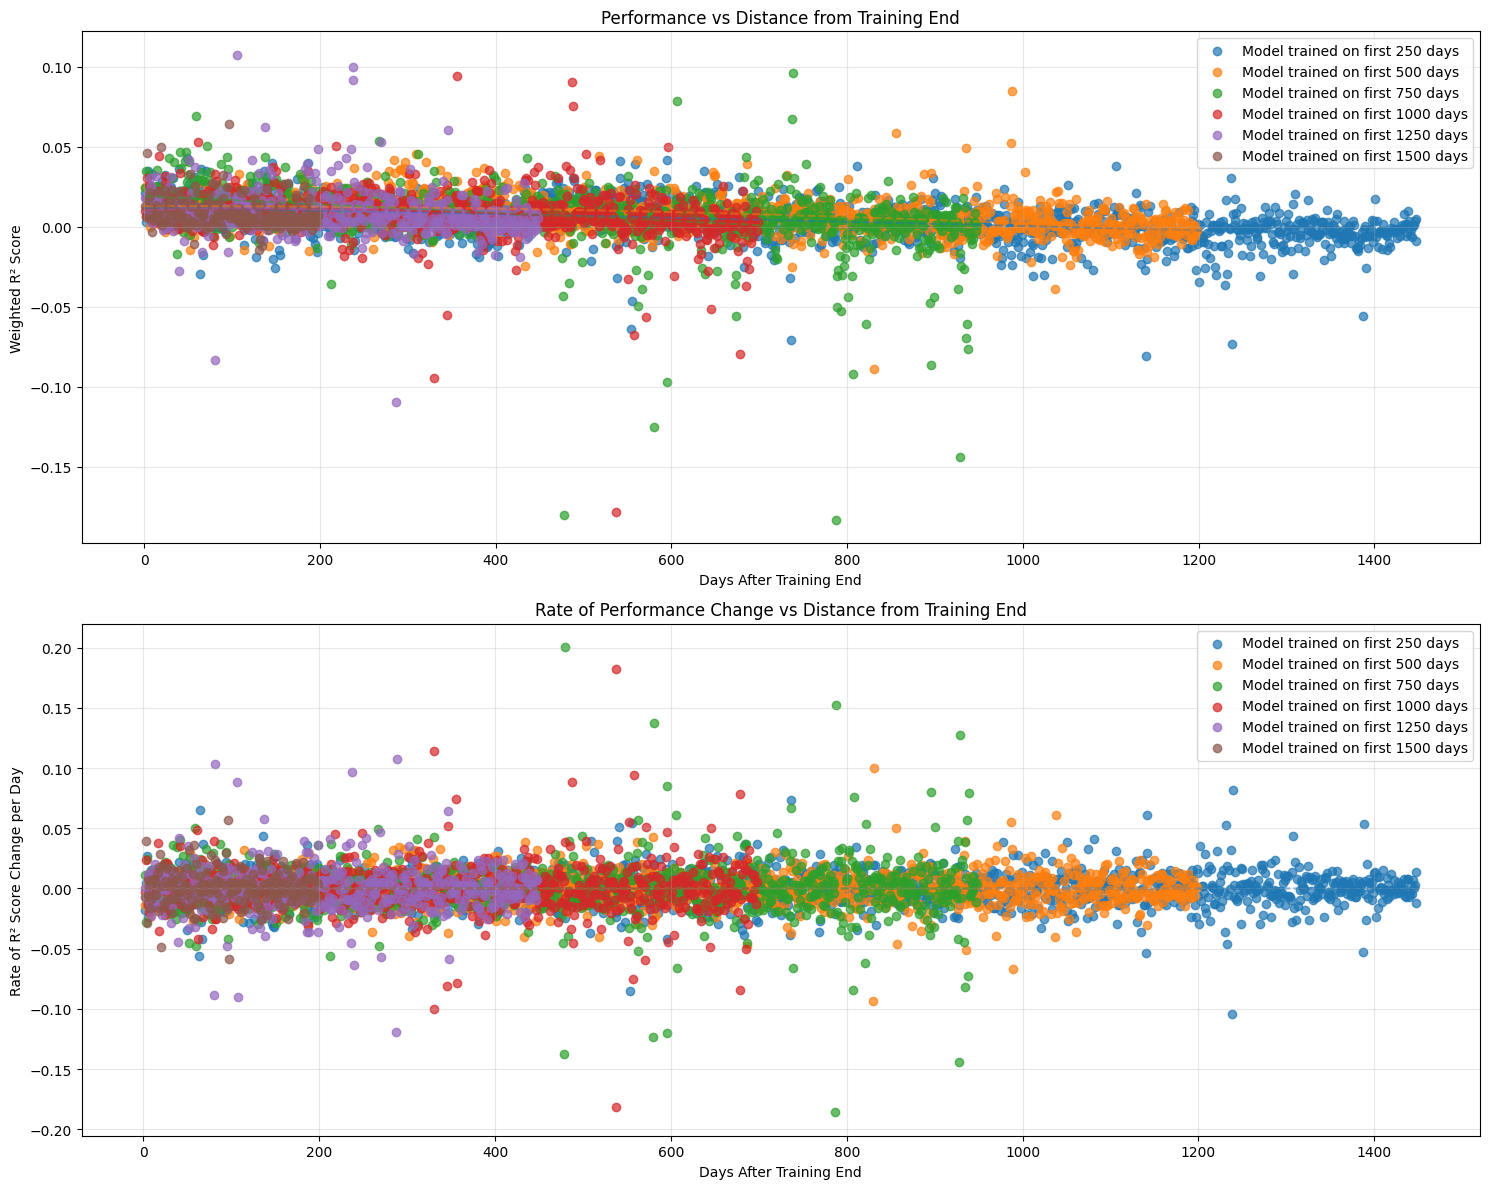


Analysis of Performance Stabilization:

Model trained on first 250 days:
Initial R² Score: 0.021106
Final R² Score: 0.004817
Total degradation: -0.016289
Performance appears to stabilize around 15 days after training

Model trained on first 500 days:
Initial R² Score: 0.024976
Final R² Score: -0.002131
Total degradation: -0.027106
Performance appears to stabilize around 4 days after training

Model trained on first 750 days:
Initial R² Score: 0.024154
Final R² Score: 0.000997
Total degradation: -0.023157
Performance appears to stabilize around 7 days after training

Model trained on first 1000 days:
Initial R² Score: 0.009796
Final R² Score: 0.002698
Total degradation: -0.007097
Performance appears to stabilize around 2 days after training

Model trained on first 1250 days:
Initial R² Score: 0.018161
Final R² Score: 0.005487
Total degradation: -0.012674
Performance appears to stabilize around 2 days after training

Model trained on first 1500 days:
Initial R² Score: 0.013173
Final R² 

In [8]:
# Analysis of performance vs distance from training
plt.figure(figsize=(15, 10))

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Top plot: Performance vs distance from training end
for model_config in MODELS:
    model_name = model_config['name']
    train_end = model_config['train_end']
    r2_col = f'r2_score_{model_name}'
    
    # Get non-null values and calculate distance from training
    valid_results = results_df[['start_day', r2_col]].dropna()
    distance_from_training = valid_results['start_day'] - train_end
    
    # Plot scores
    ax1.scatter(distance_from_training, valid_results[r2_col], alpha=0.7,
                label=f'Model trained on first {train_end} days')
    
    # Add trend line
    z = np.polyfit(distance_from_training, valid_results[r2_col], 2)  # Using quadratic fit
    p = np.poly1d(z)
    x_range = np.linspace(distance_from_training.min(), distance_from_training.max(), 100)
    ax1.plot(x_range, p(x_range), "--", alpha=0.5)

ax1.set_title('Performance vs Distance from Training End')
ax1.set_xlabel('Days After Training End')
ax1.set_ylabel('Weighted R² Score')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Bottom plot: Rate of degradation vs distance
for model_config in MODELS:
    model_name = model_config['name']
    train_end = model_config['train_end']
    r2_col = f'r2_score_{model_name}'
    
    # Get non-null values and calculate distance from training
    valid_results = results_df[['start_day', r2_col]].dropna().copy()
    valid_results['distance'] = valid_results['start_day'] - train_end
    
    # Calculate rolling performance change
    window_size = 3  # number of segments to use for rolling calculation
    valid_results['rolling_change'] = valid_results[r2_col].diff(periods=1) / valid_results['distance'].diff(periods=1)
    
    # Plot rolling change
    ax2.scatter(valid_results['distance'], valid_results['rolling_change'], alpha=0.7,
                label=f'Model trained on first {train_end} days')
    
    # Add trend line
    valid_results = valid_results.dropna()  # Remove NaN from diff calculation
    z = np.polyfit(valid_results['distance'], valid_results['rolling_change'], 1)
    p = np.poly1d(z)
    x_range = np.linspace(valid_results['distance'].min(), valid_results['distance'].max(), 100)
    ax2.plot(x_range, p(x_range), "--", alpha=0.5)

ax2.set_title('Rate of Performance Change vs Distance from Training End')
ax2.set_xlabel('Days After Training End')
ax2.set_ylabel('Rate of R² Score Change per Day')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# Print analysis of performance stabilization
print("\nAnalysis of Performance Stabilization:")
for model_config in MODELS:
    model_name = model_config['name']
    train_end = model_config['train_end']
    r2_col = f'r2_score_{model_name}'
    
    # Get non-null values and calculate distance from training
    valid_results = results_df[['start_day', r2_col]].dropna().copy()
    valid_results['distance'] = valid_results['start_day'] - train_end
    
    # Calculate rolling standard deviation of performance
    rolling_std = valid_results[r2_col].rolling(window=3, min_periods=1).std()
    
    # Find where performance starts to stabilize (std drops below threshold)
    threshold = rolling_std.mean() * 0.5  # Using 50% of mean std as threshold
    stabilization_point = valid_results['distance'][rolling_std < threshold].iloc[0] if any(rolling_std < threshold) else None
    
    print(f"\nModel trained on first {train_end} days:")
    print(f"Initial R² Score: {valid_results[r2_col].iloc[0]:.6f}")
    print(f"Final R² Score: {valid_results[r2_col].iloc[-1]:.6f}")
    print(f"Total degradation: {valid_results[r2_col].iloc[-1] - valid_results[r2_col].iloc[0]:.6f}")
    if stabilization_point is not None:
        print(f"Performance appears to stabilize around {stabilization_point:.0f} days after training")

<Figure size 1500x1200 with 0 Axes>

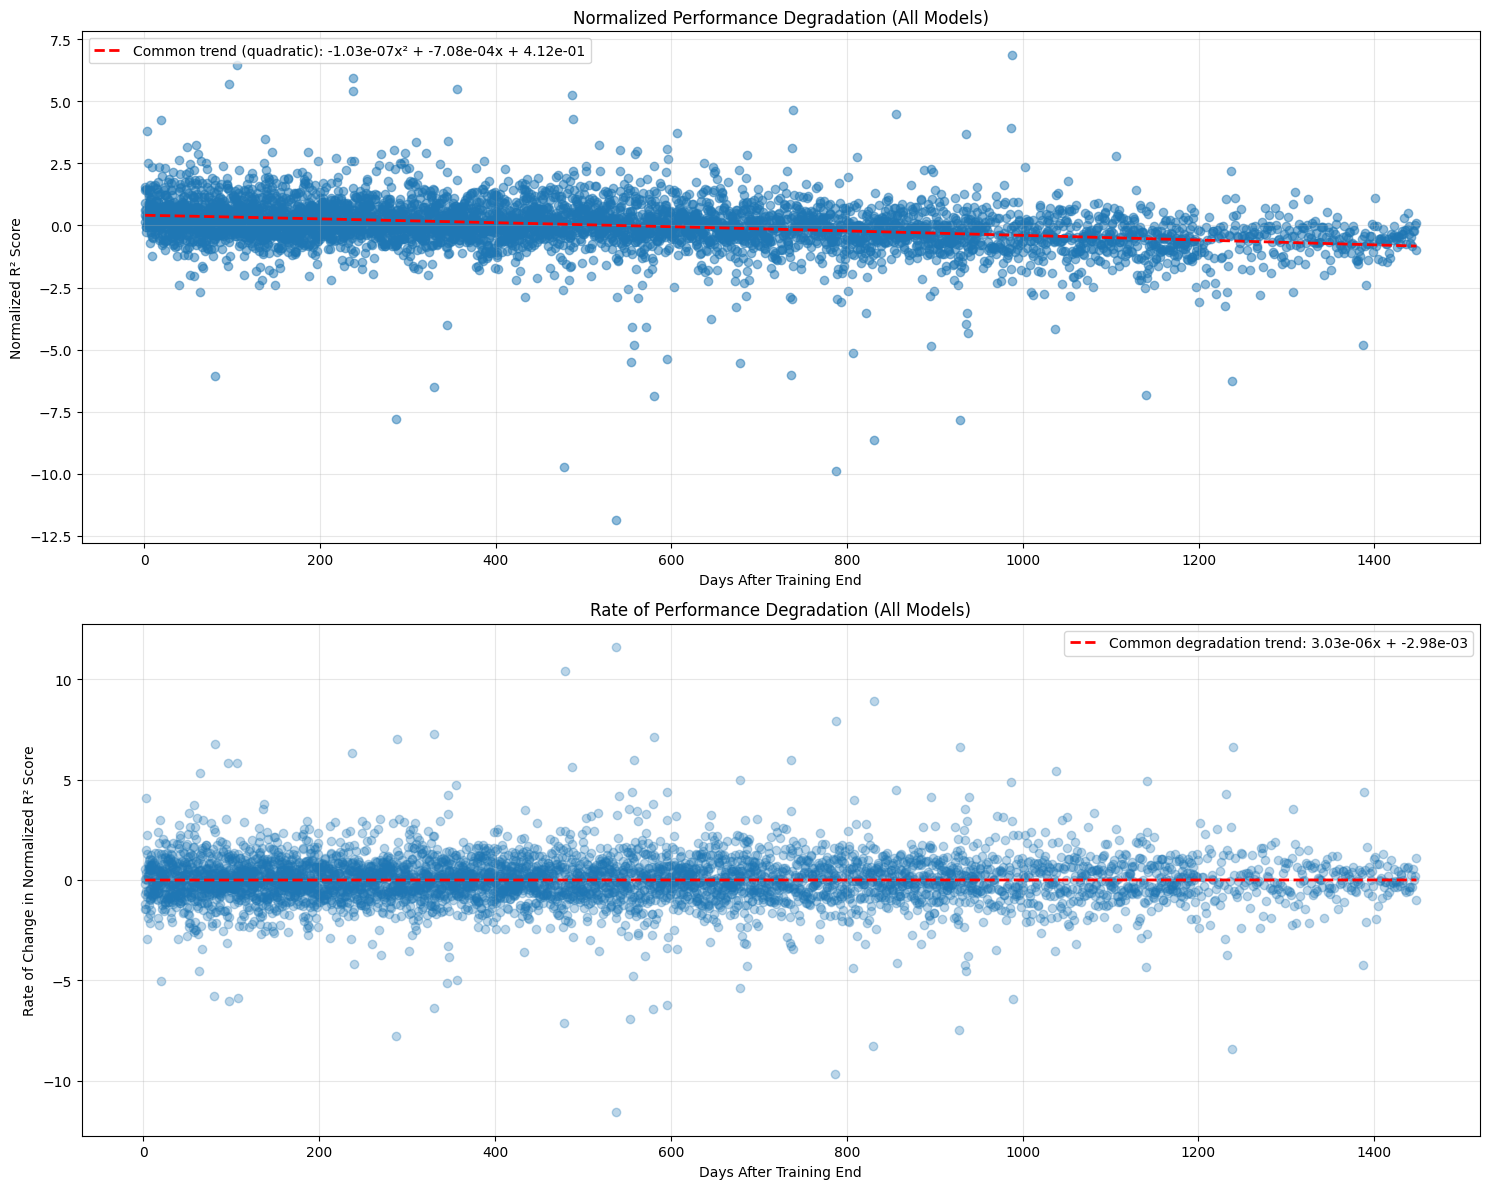


Degradation Pattern Analysis:

Performance by distance from training:
                          mean       std  count
distance                                       
(0.999, 3.0]          0.730020  0.961315     18
(3.0, 6.0]            0.927829  0.605618     18
(6.0, 9.0]            0.412159  0.837974     18
(9.0, 11.827]         0.419756  0.539766     12
(11.827, 14.0]        0.481639  0.631651     18
...                        ...       ...    ...
(1365.717, 1382.173] -0.800181  0.476169     17
(1382.173, 1398.63]  -1.050621  1.145983     16
(1398.63, 1415.087]  -0.591925  0.618356     17
(1415.087, 1431.543] -0.562770  0.321950     16
(1431.543, 1448.0]   -0.274751  0.402591     17

[300 rows x 3 columns]

Degradation Rate Analysis:
Early degradation rate (mean): -0.001995
Late degradation rate (mean): -0.000800
T-statistic: -0.034153
P-value: 0.972756


/tmp/ipykernel_3996222/671542142.py:79: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pattern_analysis = combined_df.groupby(distance_bins)['normalized_r2'].agg(['mean', 'std', 'count'])


In [15]:
# Normalize all results to compare degradation patterns
plt.figure(figsize=(15, 12))

# Create plot with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Prepare combined data for analysis
combined_data = []
for model_config in MODELS:
    model_name = model_config['name']
    train_end = model_config['train_end']
    r2_col = f'r2_score_{model_name}'
    
    # Get non-null values
    valid_results = results_df[['start_day', r2_col]].dropna().copy()
    
    # Calculate distance from training end and normalize performance
    valid_results['distance'] = valid_results['start_day'] - train_end
    valid_results['normalized_r2'] = (valid_results[r2_col] - valid_results[r2_col].mean()) / valid_results[r2_col].std()
    
    # Add to combined data with model metadata
    for _, row in valid_results.iterrows():
        combined_data.append({
            'train_end': train_end,
            'distance': row['distance'],
            'r2_score': row[r2_col],
            'normalized_r2': row['normalized_r2']
        })

# Convert to DataFrame for easier analysis
combined_df = pd.DataFrame(combined_data)

# Plot 1: All models' degradation aligned by distance from training
ax1.scatter(combined_df['distance'], combined_df['normalized_r2'], alpha=0.5)
z = np.polyfit(combined_df['distance'], combined_df['normalized_r2'], 2)
p = np.poly1d(z)
x_range = np.linspace(combined_df['distance'].min(), combined_df['distance'].max(), 100)
ax1.plot(x_range, p(x_range), "r--", linewidth=2, 
         label=f'Common trend (quadratic): {z[0]:.2e}x² + {z[1]:.2e}x + {z[2]:.2e}')

ax1.set_title('Normalized Performance Degradation (All Models)')
ax1.set_xlabel('Days After Training End')
ax1.set_ylabel('Normalized R² Score')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: Rolling average of degradation rate
window_size = 50  # days
combined_df = combined_df.sort_values('distance')
combined_df['rolling_deg_rate'] = combined_df.groupby('train_end')['normalized_r2'].diff() / \
                                 combined_df.groupby('train_end')['distance'].diff()

# Clean data for polyfit
valid_mask = ~(combined_df['distance'].isna() | combined_df['rolling_deg_rate'].isna())
valid_distances = combined_df.loc[valid_mask, 'distance']
valid_rates = combined_df.loc[valid_mask, 'rolling_deg_rate']

ax2.scatter(valid_distances, valid_rates, alpha=0.3)
z = np.polyfit(valid_distances, valid_rates, 1)
p = np.poly1d(z)
x_range = np.linspace(valid_distances.min(), valid_distances.max(), 100)
ax2.plot(x_range, p(x_range), "r--", linewidth=2,
         label=f'Common degradation trend: {z[0]:.2e}x + {z[1]:.2e}')

ax2.set_title('Rate of Performance Degradation (All Models)')
ax2.set_xlabel('Days After Training End')
ax2.set_ylabel('Rate of Change in Normalized R² Score')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# Statistical Analysis
print("\nDegradation Pattern Analysis:")

# Group data by distance ranges to look for common patterns
distance_bins = pd.qcut(combined_df['distance'], q=300)
pattern_analysis = combined_df.groupby(distance_bins)['normalized_r2'].agg(['mean', 'std', 'count'])
print("\nPerformance by distance from training:")
print(pattern_analysis)

# Test if there's a significant change in degradation rate
from scipy import stats
early_degradation = combined_df[combined_df['distance'] <= combined_df['distance'].median()]['rolling_deg_rate'].dropna()
late_degradation = combined_df[combined_df['distance'] > combined_df['distance'].median()]['rolling_deg_rate'].dropna()
t_stat, p_value = stats.ttest_ind(early_degradation, late_degradation)

print("\nDegradation Rate Analysis:")
print(f"Early degradation rate (mean): {early_degradation.mean():.6f}")
print(f"Late degradation rate (mean): {late_degradation.mean():.6f}")
print(f"T-statistic: {t_stat:.6f}")
print(f"P-value: {p_value:.6f}")